In [2]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward_aug (generic function with 1 method)

# Hilbert Matrix Problem : Probabilistic Approach

We define the Hilbert matrix $G \in \mathbb{R}^{N_{\theta}\times N_{\theta}}$ by its entries 

$$G_{i,j} = \frac{1}{i + j - 1}$$

with $N_{\theta} = 100$. We consider the inverse problem 

$$y = G \mathbb{1}\qquad \eta \sim \mathcal{N}(0, 0.1^2\mathbb{I}) \qquad \rho_{\rm prior} \sim \mathcal{N}(0, \mathbb{I})$$


We focus on the effect of the ensemble size on EAKI and
ETKI, comparing with UKI. To be concrete, we apply EAKI and ETKI with $J = N_{\theta}$,
$N_{\theta} + 1$ and $500$, and different UKIs. 
And we initialize all algorithms at the prior distribution.

We find that for ensemble-based Kalman inversion, they require at least $N_{\theta} + 1$ particles to achieve convergence.

In [7]:
function Two_Param_Linear_Test(problem_type::String, θ0_bar, θθ0_cov)
    
    N_θ = length(θ0_bar)

    if problem_type == "Hilbert"

        G = zeros(N_θ, N_θ)
        for i = 1:N_θ
            for j = 1:N_θ
                G[i,j] = 1/(i + j - 1)
            end
        end
    
        θ_ref = fill(1.0, N_θ)
        y   = G*θ_ref 
        Σ_η = Array(Diagonal(fill(0.5^2, N_θ)))
        
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
    
    Σ_post = inv(G'*(Σ_η\G) + inv(θθ0_cov))
    θ_post = θ0_bar + Σ_post*(G'*(Σ_η\(y - G*θ0_bar)))
    

    return θ_post, Σ_post, G, y, Σ_η
end


function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 9 methods)

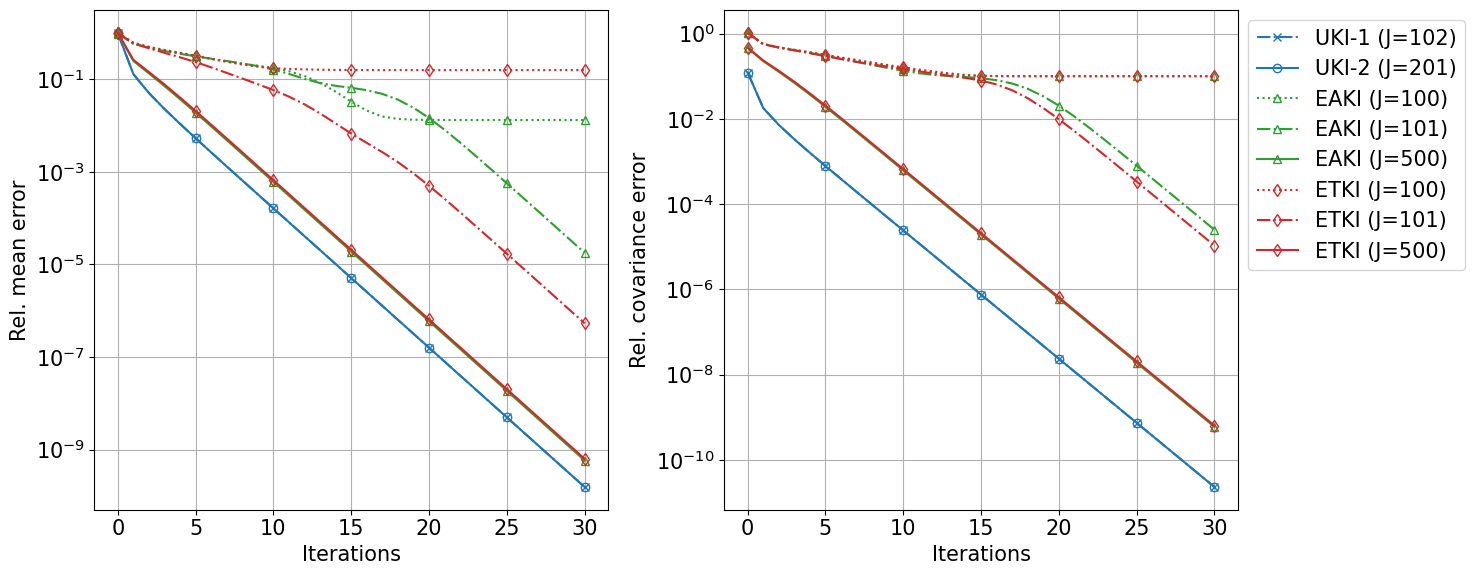

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "EAKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/hu

In [6]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()

Random.seed!(41)
α_reg = 1.0
update_freq = 1
γ = 1.0
N_iter = 30
N_θ = 100
θ0_mean = zeros(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
θθ0_cov_sqrt = θθ0_cov

prior_mean     = θ0_mean
prior_cov      = θθ0_cov
prior_cov_sqrt = θθ0_cov_sqrt

unscented_transform = "modified-n+2"

for problem_type in ("Hilbert", )
    
    θ_post, Σ_post, G, y, Σ_η = Two_Param_Linear_Test(problem_type, θ0_mean, θθ0_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    s_param_aug = Setup_Param(G, N_θ, N_y+N_θ)
    
        
    y_aug = [y ;θ0_mean]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  θθ0_cov]
     
    
    N_θ_s = N_θ
    N_θ_m = N_θ+1
    N_θ_l = 500
    
    # UKI
    uki_obj      = UKI_Run(s_param_aug, forward_aug, θ0_mean, θθ0_cov, prior_mean, prior_cov, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter; unscented_transform="modified-n+2")
    uki_2np1_obj = UKI_Run(s_param_aug, forward_aug, θ0_mean, θθ0_cov, prior_mean, prior_cov, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter; unscented_transform="modified-2n+1")
    
    
    # ETKI
    N_ens = N_θ_s
    etki_obj_s = EKI_Run(s_param_aug, forward_aug, "ETKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    
    N_ens = N_θ_m
    etki_obj_m = EKI_Run(s_param_aug, forward_aug, "ETKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    
    N_ens = N_θ_l
    etki_obj_l = EKI_Run(s_param_aug, forward_aug, "ETKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    
    
    # EAKI
    N_ens = N_θ_s
    eaki_obj_s = EKI_Run(s_param_aug, forward_aug, "EAKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)

    N_ens = N_θ_m
    eaki_obj_m = EKI_Run(s_param_aug, forward_aug, "EAKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    
    N_ens = N_θ_l
    eaki_obj_l = EKI_Run(s_param_aug, forward_aug, "EAKI", θ0_mean, θθ0_cov_sqrt, prior_mean, prior_cov_sqrt, N_ens,
    y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    
    

    uki_errors    = zeros(FT, N_iter+1, 2)
    uki_2np1_errors    = zeros(FT, N_iter+1, 2)
   
    
    eaki_s_errors = zeros(FT, N_iter+1, 2)
    eaki_m_errors = zeros(FT, N_iter+1, 2)
    eaki_l_errors = zeros(FT, N_iter+1, 2)
    etki_s_errors = zeros(FT, N_iter+1, 2)
    etki_m_errors = zeros(FT, N_iter+1, 2)
    etki_l_errors = zeros(FT, N_iter+1, 2)
    
    
    for i = 1:N_iter+1
        
        
        uki_errors[i, 1] = norm(uki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_errors[i, 2] = norm(uki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
          
        uki_2np1_errors[i, 1] = norm(uki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_2np1_errors[i, 2] = norm(uki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        
        eaki_s_errors[i, 1] = norm(dropdims(mean(eaki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_s_errors[i, 2] = norm(construct_cov(eaki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_m_errors[i, 1] = norm(dropdims(mean(eaki_obj_m.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_m_errors[i, 2] = norm(construct_cov(eaki_obj_m.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_l_errors[i, 1] = norm(dropdims(mean(eaki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_l_errors[i, 2] = norm(construct_cov(eaki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_s_errors[i, 1] = norm(dropdims(mean(etki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_s_errors[i, 2] = norm(construct_cov(etki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_m_errors[i, 1] = norm(dropdims(mean(etki_obj_m.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_m_errors[i, 2] = norm(construct_cov(etki_obj_m.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_l_errors[i, 1] = norm(dropdims(mean(etki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_l_errors[i, 2] = norm(construct_cov(etki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
         
    end
    
    ites = Array(0:N_iter)
    mkevery = 5
    fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=false, sharey=false, figsize=(15,6))
    ax[1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = mkevery)
    ax[1].semilogy(ites, uki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = mkevery)
    ax[1].semilogy(ites, eaki_s_errors[:, 1], ":^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_s))", markevery = mkevery)
    ax[1].semilogy(ites, eaki_m_errors[:, 1], "-.^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_m))", markevery = mkevery)
    ax[1].semilogy(ites, eaki_l_errors[:, 1], "-^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_l))", markevery = mkevery)
    ax[1].semilogy(ites, etki_s_errors[:, 1], ":d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_s))", markevery = mkevery)
    ax[1].semilogy(ites, etki_m_errors[:, 1], "-.d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_m))", markevery = mkevery)
    ax[1].semilogy(ites, etki_l_errors[:, 1], "-d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_l))", markevery = mkevery)
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Rel. mean error")
    ax[1].grid("on")
   
    
    ax[2].semilogy(ites, uki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))", markevery = mkevery)
    ax[2].semilogy(ites, uki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))", markevery = mkevery)
    ax[2].semilogy(ites, eaki_s_errors[:, 2], ":^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_s))", markevery = mkevery)
    ax[2].semilogy(ites, eaki_m_errors[:, 2], "-.^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_m))", markevery = mkevery)
    ax[2].semilogy(ites, eaki_l_errors[:, 2], "-^", color = "C2", fillstyle="none", label="EAKI (J=$(N_θ_l))", markevery = mkevery)
    ax[2].semilogy(ites, etki_s_errors[:, 2], ":d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_s))", markevery = mkevery)
    ax[2].semilogy(ites, etki_m_errors[:, 2], "-.d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_m))", markevery = mkevery)
    ax[2].semilogy(ites, etki_l_errors[:, 2], "-d", color = "C3", fillstyle="none", label="ETKI (J=$(N_θ_l))", markevery = mkevery)
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Rel. covariance error")
    ax[2].grid("on")
    ax[2].legend(bbox_to_anchor=(1.0, 1.0))
    fig.tight_layout()
end


